In [21]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial,integrate

import matplotlib.pyplot as plt

In [22]:
# podatki
ρ = 2700 # kg /m3
E = 70e9 # Pa
L = 1 # m

b = 0.010 # m
h = 0.010 # m
A = b*h # m^2
I = b*h**3/12 # m^4

In [23]:
# transformacijska matrika
def T(α):
    
    T = np.array([[ np.cos(α), np.sin(α), 0,         0,         0, 0],
                   [-np.sin(α), np.cos(α), 0,         0,         0, 0],
                   [         0,         0, 1,         0,         0, 0],
                   [         0,         0, 0, np.cos(α), np.sin(α), 0],
                   [         0,         0, 0,-np.sin(α), np.cos(α), 0],
                   [         0,         0, 0,         0,         0, 1]])
        
    return T

In [24]:
# masna matrika
def M_e(A, L, ρ, α):

    M_lok = ρ*A*L*np.array([[1/3,         0,         0, 1/6,         0,         0],
                            [  0,     13/35,  11*L/210,   0,      9/70, -13*L/420],
                            [  0,  11*L/210,  L**2/105,   0,  13*L/420, -L**2/140],
                            [1/6,         0,         0, 1/3,         0,         0],
                            [  0,      9/70,  13*L/420,   0,     13/35, -11*L/210],
                            [  0, -13*L/420, -L**2/140,   0, -11*L/210,  L**2/105]])
    
    return T(α).T @ M_lok @ T(α)

In [25]:
# togostna matrika
def K_e(A, E, I, L, α):

    K_lok = E/L*np.array([[ A,          0,      0, -A,          0,      0],
                          [ 0,  12*I/L**2,  6*I/L,  0, -12*I/L**2,  6*I/L],
                          [ 0,      6*I/L,    4*I,  0,     -6*I/L,    2*I],
                          [-A,          0,      0,  A,          0,      0],
                          [ 0, -12*I/L**2, -6*I/L,  0,  12*I/L**2, -6*I/L],
                          [ 0,      6*I/L,    2*I,  0,     -6*I/L,    4*I]])
    
    return T(α).T @ K_lok @ T(α)

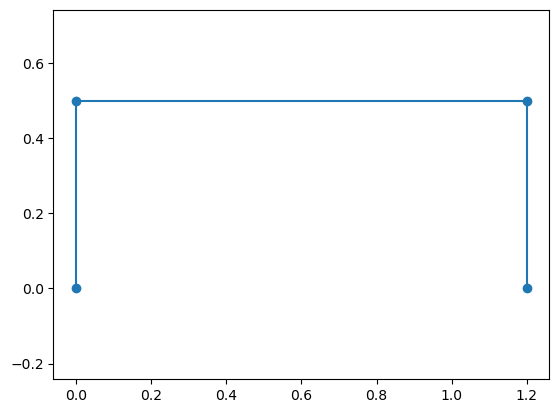

In [26]:
# vozlišča in elementi
%matplotlib inline
a = 1.2*L
b = 0.5*L
vozlisca = np.array([[0,0],[0,b],[a,b],[a,0]])
elementi = np.array([[0,1],[1,2],[2,3]])

[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
plt.axis('equal');

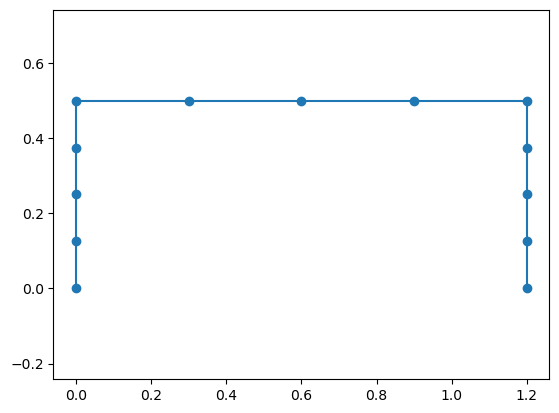

In [27]:
n = 5
vozlisca_AB = np.array([[0,y] for y in np.linspace(0,b,n)])
vozlisca_BC = np.array([[x,b] for x in np.linspace(0,a,n)])
vozlisca_CD = np.array([[a,y] for y in np.linspace(b,0,n)])

vozlisca = np.vstack([vozlisca_AB, vozlisca_BC[1:], vozlisca_CD[1:]])
elementi = np.array([[i,i+1] for i in range(len(vozlisca)-1)])

[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
plt.axis('equal');

In [28]:
# sestav globalne masne in togostne matrike
M_glob = np.zeros((vozlisca.shape[0]*3,vozlisca.shape[0]*3))
K_glob = np.zeros((vozlisca.shape[0]*3,vozlisca.shape[0]*3))

for element in elementi:
    # dolžina elementa
    Le = sp.spatial.distance.euclidean(vozlisca[element[0]], vozlisca[element[1]])
    
    # kot zasuka
    αe = np.arctan2(np.diff(vozlisca[element,1]) , np.diff(vozlisca[element,0]))[0]
    
    # indeksi prostostnih stopenj
    ind = np.array([3*element[0],3*element[0]+1,3*element[0]+2,3*element[1],3*element[1]+1,3*element[1]+2])
    
    # priševanje prispevkov posameznih elementov
    M_glob[ind[:,None],ind] += M_e(A, Le, ρ, αe)
    K_glob[ind[:,None],ind] += K_e(A, E, I, Le, αe)

In [29]:
# ROBNI POGOJI
ind_vpetih_ps = np.array([0,1,2,-2])

C = np.zeros((len(ind_vpetih_ps),len(M_glob)))
C[np.arange(len(ind_vpetih_ps)),ind_vpetih_ps] = 1

L = sp.linalg.null_space(C)

M_glob_rp = L.T @ M_glob @ L
K_glob_rp = L.T @ K_glob @ L

### Predpis vzbujanja

In [30]:
# vektor zunanjih obremenitev - izberemo točko B v x smeri

# trajanje impulza
t0 = 0.1 # s
# amplituda impulza
amp = 100 # N

tocka_B = np.array([0,b])

ind_B = np.where((vozlisca == tocka_B).all(axis=1))[0]
ind_x, ind_y, ind_phi = 3*ind_B + np.array([0,1,2])

def f_glob_rp(t):
    f_glob = np.zeros(3*len(vozlisca))
    
    if t < t0:
        f_B = amp*np.sin(np.pi*t/t0)
        
    else:
        f_B = 0
    
    f_glob[ind_x] = f_B
    return L.T @ f_glob

### Reševanje - preko scipy

In [31]:
# dodamo dušenje
α = 5e-1
β = 3e-3
C_glob_rp = α*M_glob_rp + β*K_glob_rp

# prehod na sistem DE 1. reda
D = np.block([
    [-np.linalg.inv(M_glob_rp) @ C_glob_rp , -np.linalg.inv(M_glob_rp) @ K_glob_rp],
    [np.eye(M_glob_rp.shape[0]) , np.zeros_like(M_glob_rp)]
])

def int_fun(t,v):
    F = np.block([np.linalg.inv(M_glob_rp)@f_glob_rp(t),np.zeros_like(f_glob_rp(t))])
    return D @ v + F

# začetni pogoji
Q0 = np.zeros(M_glob_rp.shape[0])
dQ0 = np.zeros(M_glob_rp.shape[0])

q0 = np.hstack([dQ0, Q0])

In [32]:
#REŠEVANJE
t_min = 0
t_max = 2

t_e = np.linspace(t_min,t_max,500)

res = sp.integrate.solve_ivp(int_fun, t_span=(t_e[0], t_e[-1]), method='Radau', y0=q0, t_eval = t_e)

q_dot, q = np.split(res.y,2)
u = L @ q

In [33]:
u.shape

(39, 500)

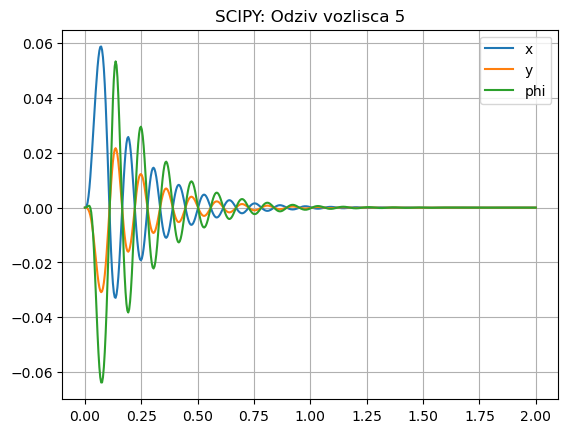

In [34]:
# izris odziva za izbrano vozlisce
ind_vozlisca_odz = 5
ind_x_odz, ind_y_odz, ind_phi_odz = 3*ind_vozlisca_odz + np.array([0,1,2])

plt.title('SCIPY: Odziv vozlisca '+str(ind_vozlisca_odz))
plt.plot(res.t, u[ind_x_odz],label='x')
plt.plot(res.t, u[ind_y_odz],label='y')
plt.plot(res.t, u[ind_phi_odz],label='phi')
plt.grid()
plt.legend()

In [35]:
%matplotlib qt
import matplotlib.animation as animation

fig = plt.figure() 
ax = plt.axes(xlim =(-0.2*a,1.3*a), 
                ylim =(-0.2*b,1.1*b)) 

line, = ax.plot([], [],'-o') 

def init(): 
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(vozlisca[:,0] + u[0::3,i], vozlisca[:,1] + u[1::3,i])
    return line,

ani = animation.FuncAnimation(fig, animate, init_func = init, interval = 1, blit = True)

plt.get_current_fig_manager().window.showMaximized()
plt.show()

In [36]:
%matplotlib inline

### Reševanje - preko MKR


In [37]:
eig_val = np.linalg.eigvals(np.linalg.inv(M_glob_rp) @ K_glob_rp)

dt = 2 / np.max(np.abs(eig_val))**0.5
#dt = 1.1 * dt # samo za prikaz

n_step = int((t_max-t_min)/dt) 

# časovni vektor
t_mkr = np.linspace(t_min,t_max,n_step + 1)

In [38]:
n_step

123604

In [39]:
# inicializacija
q_mkr = []

# ničti korak (k = 0, t = 0)
q_mkr_0 = Q0
q_mkr.append(q_mkr_0)

# prvi korak (k = 1, t = 1*dt)
d = (2/dt**2 * M_glob_rp - K_glob_rp) @ Q0 + (2/dt * M_glob_rp - C_glob_rp) @ dQ0 + f_glob_rp(0)
q_mkr_1 = dt**2/2 * np.linalg.inv(M_glob_rp) @ d
q_mkr.append(q_mkr_1)

from tqdm import tqdm

D = 1/dt**2 * M_glob_rp + 1/2/dt * C_glob_rp
Dinv = np.linalg.inv(D)
for k in tqdm(range(1,n_step)): #(torej k = 2, k = 3 ...)
    q_mkr_kplus1 = Dinv @ ((2/dt**2 * M_glob_rp - K_glob_rp) @ q_mkr[k] + (1/2/dt * C_glob_rp - 1/dt**2 * M_glob_rp) @ q_mkr[k-1] + f_glob_rp(k * dt))
    q_mkr.append(q_mkr_kplus1)

u_mkr = L @ np.array(q_mkr).T

100%|██████████| 123603/123603 [00:06<00:00, 19919.65it/s]


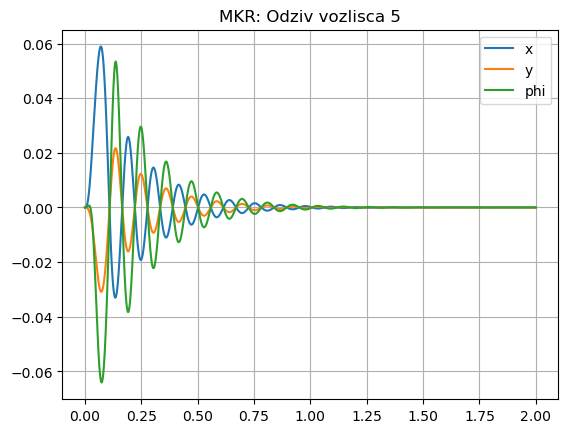

In [40]:
plt.title('MKR: Odziv vozlisca '+str(ind_vozlisca_odz))
plt.plot(t_mkr, u_mkr[ind_x_odz],label='x')
plt.plot(t_mkr, u_mkr[ind_y_odz],label='y')
plt.plot(t_mkr, u_mkr[ind_phi_odz],label='phi')
plt.grid()
plt.legend()